# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.4.0+cu121


In [2]:
import torch
print(torch.cuda.is_available())


True


# Preparing Training and Test Sets

In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self,image_dirs,transform):
        def get_images(class_name):
            images=[x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'found {len(images)} {class_name} examples')
            return images
        
        self.images={}
        self.class_names=['normal','viral','covid']
        
        for c in self.class_names:
            self.images[c]=get_images(c)
        
        self.image_dirs=image_dirs
        self.transforms=transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self,index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path=os.path.join(self.image_dirs[class_name],image_name)
        image=Image.open(image_path).convert('RGB')
        return self.transforms(image),self.class_names.index(class_name)

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std=[0.229,0.224,0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std=[0.229,0.224,0.225])
])

# Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}
train_dataset = ChestXRayDataset(train_dirs,train_transform)

found 1311 normal examples
found 1315 viral examples
found 189 covid examples


In [9]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs,test_transform)

found 30 normal examples
found 30 viral examples
found 30 covid examples


In [10]:
batch_size=6

dl_train = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                      shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,
                                      shuffle=True)

print('num of training batches', len(dl_train))
print('num of test batches', len(dl_test))

num of training batches 470
num of test batches 15


# Data Visualization

In [11]:
class_names=train_dataset.class_names

def show_images(images,labels,preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1,6,i+1 ,xticks=[],yticks=[])
        image=image.numpy().transpose((1,2,0))
        mean=np.array([0.485,0.456,0.406])
        std= np.array([0.229,0.224,0.225])
        image=image*std+mean
        image=np.clip(image,0.,1.)
        plt.imshow(image)
        
        col = 'green' if preds[i]==labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}',color=col)
    plt.tight_layout()
    plt.show()

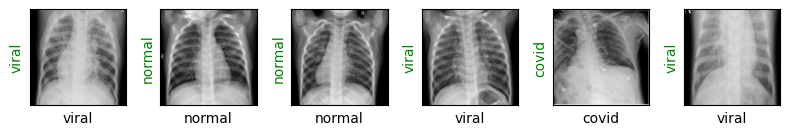

In [12]:
images,labels = next(iter(dl_train))
show_images(images,labels,labels)

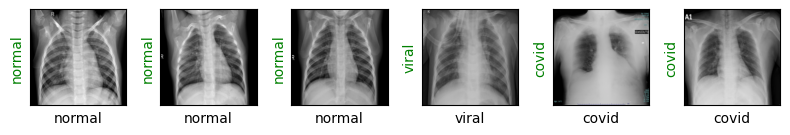

In [13]:
images,labels = next(iter(dl_test))
show_images(images,labels,labels)

# Creating the Model

In [14]:
resnet18=torchvision.models.resnet18(pretrained=True)
print(resnet18)

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
resnet18.fc=torch.nn.Linear(in_features=512 , out_features=3)
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet18.parameters(),lr=3e-5)
device=torch.device("cuda")
resnet18.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    images, labels = images.to(device), labels.to(device)  # Move data to GPU
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())  

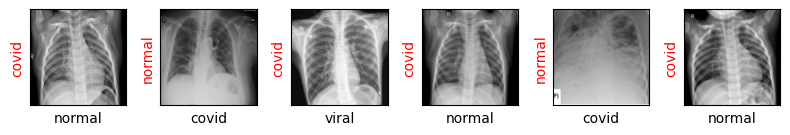

In [17]:
show_preds()

# Training the Model

In [25]:
def train(epochs):
    print('starting training...')
    for e in range(epochs):
        print('=' * 20)
        print(f'starting epoch {e+1}/{epochs}')
        print('=' * 20)

        train_loss = 0

        resnet18.train()

        for train_step, (images, labels) in enumerate(dl_train):
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()

                for val_step, (images, labels) in enumerate(dl_test):
                    # Move data to GPU
                    images, labels = images.to(device), labels.to(device)

                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).cpu().numpy())  # Move preds to CPU before converting to NumPy

                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()

                resnet18.train()

                if acc > 0.95:
                    print('performance condition satisfied')
                    return

        train_loss /= (train_step + 1)
        print(f'training loss: {train_loss:.4f}')

starting training...
starting epoch 1/1
Evaluating at step 0
val loss: 1.1534, Acc: 0.4222


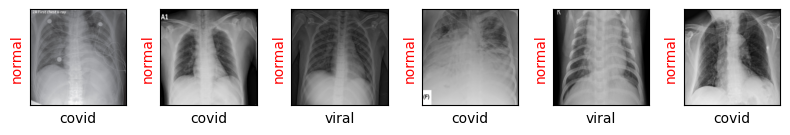

Evaluating at step 20
val loss: 0.4702, Acc: 0.8000


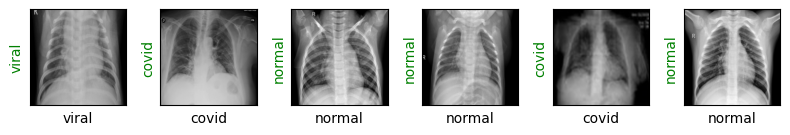

Evaluating at step 40
val loss: 0.2941, Acc: 0.9000


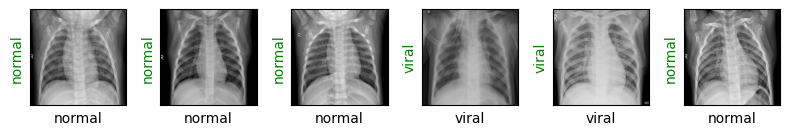

Evaluating at step 60
val loss: 0.2819, Acc: 0.8556


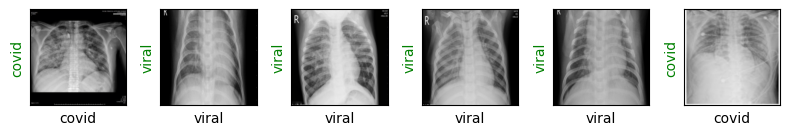

Evaluating at step 80
val loss: 0.1599, Acc: 0.9333


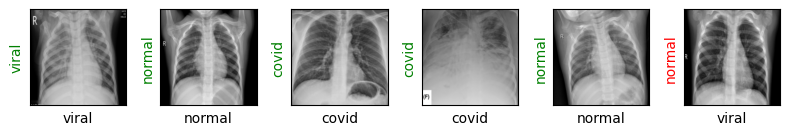

Evaluating at step 100
val loss: 0.1601, Acc: 0.9333


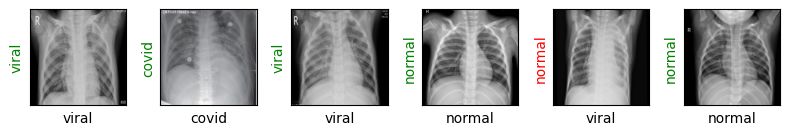

Evaluating at step 120
val loss: 0.1323, Acc: 0.9444


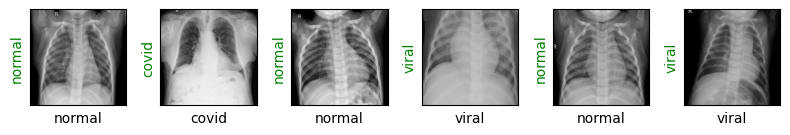

Evaluating at step 140
val loss: 0.1846, Acc: 0.9000


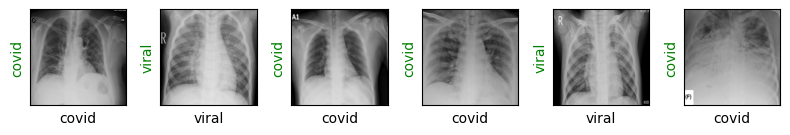

Evaluating at step 160
val loss: 0.1634, Acc: 0.9111


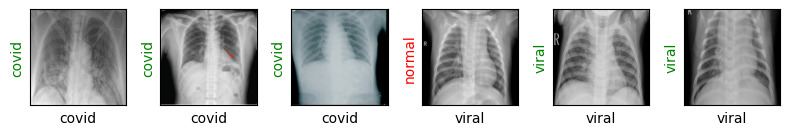

Evaluating at step 180
val loss: 0.1366, Acc: 0.9444


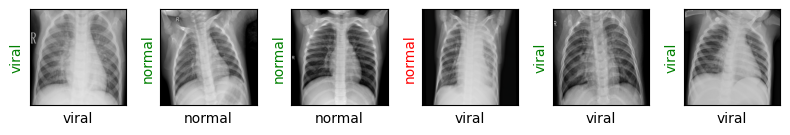

Evaluating at step 200
val loss: 0.1684, Acc: 0.9222


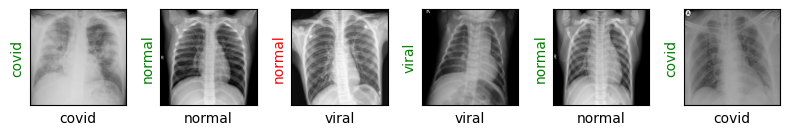

Evaluating at step 220
val loss: 0.1395, Acc: 0.9444


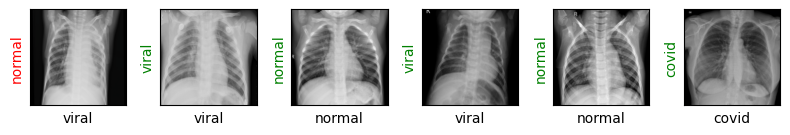

Evaluating at step 240
val loss: 0.1507, Acc: 0.9556


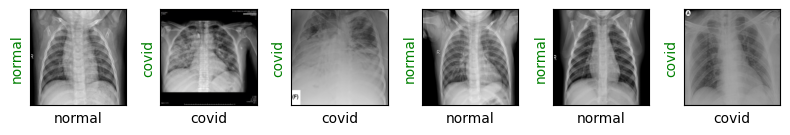

performance condition satisfied


In [28]:
train(epochs=1)

# Final Results

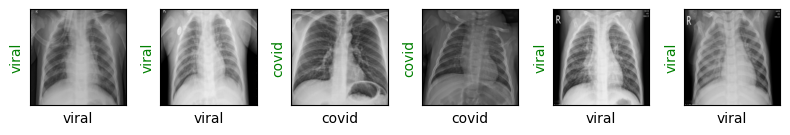

In [30]:
show_preds()

In [31]:
torch.save(resnet18.state_dict(), 'resnet18.pth')